# Load necessary packages

In [1]:
import pandas as pd
import numpy as np

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates

import matplotlib.font_manager as font_manager
mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'SF Mono'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

import tensorflow as tf

from entsoe import EntsoePandasClient

In [2]:
features = pd.read_pickle(f"./features.pkl")

ID3 = pd.DataFrame()

ID3['ID3'] = features['ID3']

In [3]:
ID3['ID3']

2015-01-01 05:00:00+00:00    27.500000
2015-01-01 06:00:00+00:00    26.780822
2015-01-01 07:00:00+00:00    25.852273
2015-01-01 08:00:00+00:00    24.400000
2015-01-01 09:00:00+00:00    25.625000
                               ...    
2018-12-21 23:00:00+00:00    50.911996
2018-12-22 00:00:00+00:00    53.554378
2018-12-22 01:00:00+00:00    53.716854
2018-12-22 02:00:00+00:00    52.950763
2018-12-22 03:00:00+00:00    53.277543
Name: ID3, Length: 33845, dtype: float64

In [4]:
features.tail(5)

,ID3,VOL,MCP,LOAD,LOAD_F,LOAD_FE,ID3 (-4),ID3 (-5),ID3 (-6),ID3 (-7),...,HOD 14,HOD 15,HOD 16,HOD 17,HOD 18,HOD 19,HOD 20,HOD 21,HOD 22,HOD 23
2018-12-21 23:00:00+00:00,50.911996,499.5,50.63,11756.25,12950.00,1193.75,53.277543,53.479330,54.977402,57.227163,...,0,0,0,0,0,0,0,0,0,1
2018-12-22 00:00:00+00:00,53.554378,309.1,53.07,11164.25,12318.00,1153.75,53.479330,54.977402,57.227163,57.961460,...,0,0,0,0,0,0,0,0,0,0
2018-12-22 01:00:00+00:00,53.716854,438.8,48.50,10796.75,11741.50,944.75,54.977402,57.227163,57.961460,58.304843,...,0,0,0,0,0,0,0,0,0,0
2018-12-22 02:00:00+00:00,52.950763,294.6,46.54,10626.25,11420.75,794.50,57.227163,57.961460,58.304843,57.755109,...,0,0,0,0,0,0,0,0,0,0
2018-12-22 03:00:00+00:00,53.277543,439.2,39.50,10685.50,11313.00,627.50,57.961460,58.304843,57.755109,57.734450,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# def ts_train_test(ID3, time_steps, for_periods):

#     # Create training and test sets
#     mask = (ID3.index.year < 2018)
#     ts_train = ID3.loc[mask]['ID3'].values
#     ts_train = ts_train.reshape(1, -1).transpose()

#     mask = (ID3.index.year == 2018)
#     ts_test = ID3.loc[mask]['ID3'].values
#     ts_test = ts_test.reshape(1, -1).transpose()

#     # ts_train = ID3[:'2018'].iloc['ID3'].values
#     # ts_test  = ID3['2019':].iloc['ID3'].values

#     # Scale the data
#     from sklearn.preprocessing import MinMaxScaler
#     sc = MinMaxScaler(feature_range=(0,1))
#     ts_train_unscaled = ts_train
#     ts_train = sc.fit_transform(ts_train)

#     # Create training data of s samples and t time steps
#     X_train = []
#     y_train = []
#     y_train_stacked = []
    
#     for i in range(time_steps, len(ts_train)-1): 
#         X_train.append(ts_train[i-time_steps:i,0])
#         y_train.append(ts_train[i:i+for_periods,0])
#     X_train, y_train = np.array(X_train), np.array(y_train)

#     # Reshape X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#     # Prepare to create X_test
#     inputs = pd.concat((ID3['ID3'][:'2018'], ID3['ID3']['2019':]),axis=0).values
#     inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
#     inputs = inputs.reshape(-1,1)
#     inputs  = sc.transform(inputs)

#     X_test = []
#     for i in range(time_steps, len(ts_test)+time_steps-for_periods):
#         X_test.append(inputs[i-time_steps:i,0])
        
#     X_test = np.array(X_test)
#     X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#     return X_train, y_train , X_test, sc

# ##########################################################################
# X_train, y_train, X_test, sc = ts_train_test(ID3, 5, 2)
# ##########################################################################

# X_train.shape[0], X_train.shape[1]

# print(X_train)

In [6]:
time_steps = 6
for_periods = 1

lag = 4

# Create training and test sets
mask = (ID3.index.year < 2018)
ts_train = ID3.loc[mask]['ID3'].values
ts_train = ts_train.reshape(1, -1).transpose()

mask = (ID3.index.year == 2018)
ts_test = ID3.loc[mask]['ID3'].values
ts_test = ts_test.reshape(1, -1).transpose()

# Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

ts_train_unscaled = ts_train
ts_train = sc.fit_transform(ts_train)

# Create training data of s samples and t time steps
X_train = []
y_train = []
y_train_stacked = []

for i in range(time_steps+lag, len(ts_train)-1): 
    X_train.append(ts_train[i-lag-time_steps:i-lag,0])
    y_train.append(ts_train[i:i+for_periods,0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train)

# Reshape X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Prepare to create X_test
inputs = pd.concat((ID3['ID3'][:'2018'], ID3['ID3']['2019':]),axis=0).values
inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(time_steps+lag, len(ts_test)+time_steps-for_periods):
    X_test.append(inputs[i-lag-time_steps:i-lag,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

X_train.shape[0], X_train.shape[1]

print(X_train)
print(y_train)

[[0.11149121 0.10957419 0.10709908 0.10322794 0.10649326 0.11575613]
 [0.10957419 0.10709908 0.10322794 0.10649326 0.11575613 0.10844484]
 [0.10709908 0.10322794 0.10649326 0.11575613 0.10844484 0.10768885]
 ...
 [0.12133775 0.13099377 0.1402162  0.14941553 0.17535489 0.17108734]
 [0.13099377 0.1402162  0.14941553 0.17535489 0.17108734 0.19165164]
 [0.1402162  0.14941553 0.17535489 0.17108734 0.19165164 0.17957977]]
[[[0.11149121]
  [0.10957419]
  [0.10709908]
  [0.10322794]
  [0.10649326]
  [0.11575613]]

 [[0.10957419]
  [0.10709908]
  [0.10322794]
  [0.10649326]
  [0.11575613]
  [0.10844484]]

 [[0.10709908]
  [0.10322794]
  [0.10649326]
  [0.11575613]
  [0.10844484]
  [0.10768885]]

 ...

 [[0.12133775]
  [0.13099377]
  [0.1402162 ]
  [0.14941553]
  [0.17535489]
  [0.17108734]]

 [[0.13099377]
  [0.1402162 ]
  [0.14941553]
  [0.17535489]
  [0.17108734]
  [0.19165164]]

 [[0.1402162 ]
  [0.14941553]
  [0.17535489]
  [0.17108734]
  [0.19165164]
  [0.17957977]]]
[[0.13569758]
 [0.1324

In [7]:
X_train.shape[0], X_train.shape[1]

(25374, 6)

In [8]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print(), print(colored(f'There are {X_train.shape[0]} samples in the training data', 'green'))
print(colored(f'There are {X_test.shape[0]} samples in the test data', 'green')), print()

print(X_train_see)
print(y_train_see)


There are 25374 samples in the training data
There are 8455 samples in the test data

              0         1         2         3         4         5
0      0.111491  0.109574  0.107099  0.103228  0.106493  0.115756
1      0.109574  0.107099  0.103228  0.106493  0.115756  0.108445
2      0.107099  0.103228  0.106493  0.115756  0.108445  0.107689
3      0.103228  0.106493  0.115756  0.108445  0.107689  0.111594
4      0.106493  0.115756  0.108445  0.107689  0.111594  0.122102
...         ...       ...       ...       ...       ...       ...
25369  0.110813  0.114077  0.121338  0.130994  0.140216  0.149416
25370  0.114077  0.121338  0.130994  0.140216  0.149416  0.175355
25371  0.121338  0.130994  0.140216  0.149416  0.175355  0.171087
25372  0.130994  0.140216  0.149416  0.175355  0.171087  0.191652
25373  0.140216  0.149416  0.175355  0.171087  0.191652  0.179580

[25374 rows x 6 columns]
              0
0      0.135698
1      0.132472
2      0.132979
3      0.109844
4      0.131233

In [9]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model_lstm.add(LSTM(units = 100, return_sequences = True))
    model_lstm.add(LSTM(units = 50, return_sequences = False))
    
    model_lstm.add(Dense(units = 1, activation='linear'))

    optimizer = Adam(clipvalue=0.5)
    # model_lstm.compile(loss = 'mse', optimizer=optimizer)

    # Compiling
    model_lstm.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    model_lstm.fit(X_train,y_train,epochs=50,batch_size=16, verbose=1)

    LSTM_prediction = model_lstm.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    # self.model = model_lstm

    return model_lstm, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)

Epoch 1/50
1586/1586 [==============================] - 24s 15ms/step - loss: 0.0015
Epoch 2/50
1586/1586 [==============================] - 25s 15ms/step - loss: 0.0013
Epoch 3/50
1586/1586 [==============================] - 25s 16ms/step - loss: 0.0013
Epoch 4/50
1586/1586 [==============================] - 25s 16ms/step - loss: 0.0013
Epoch 5/50
1586/1586 [==============================] - 26s 16ms/step - loss: 0.0013
Epoch 6/50
1586/1586 [==============================] - 26s 16ms/step - loss: 0.0013
Epoch 7/50
1586/1586 [==============================] - 26s 17ms/step - loss: 0.0013
Epoch 8/50
1586/1586 [==============================] - 26s 16ms/step - loss: 0.0013
Epoch 9/50
1586/1586 [==============================] - 26s 16ms/step - loss: 0.0013
Epoch 10/50
1586/1586 [==============================] - 28s 18ms/step - loss: 0.0013
Epoch 11/50
1586/1586 [==============================] - 24s 15ms/step - loss: 0.0013
Epoch 12/50
1586/1586 [==============================] - 22s 14

In [18]:
def actual_pred_plot(preds):

    actual_pred = pd.DataFrame()

    mask = (ID3.index.year == 2018)
    actual_pred['Actual'] = ID3.loc[mask]['ID3'][0:len(preds)]
    actual_pred['Predicted'] = preds[:, 0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    actual_pred['Actual'] = actual_pred['Actual'].astype(int)
    actual_pred['Predicted'] = actual_pred['Predicted'].astype(int)
    m.update_state(np.array(actual_pred['Actual']), np.array(actual_pred['Predicted']))
    
    return (m.result().numpy(), actual_pred)

m, prediction = actual_pred_plot(LSTM_prediction)

In [11]:
# X = features.drop(labels=['ID3', 'VOL', 'LOAD_F', 'LOAD_FE'], axis=1)
# y = features['ID3']

# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size = 0.3,
#     random_state = 0,
#     shuffle = True)

# X_train.shape, X_test.shape

In [12]:
# X_train_unscaled = X_train
# X_test_unscaled = X_test

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train_unscaled)

# X_test = scaler.transform(X_test_unscaled)

In [13]:
# def MLP_model(X_train, y_train, X_test):
#     # create a model
#     from keras.models import Sequential
#     from keras.layers import Dense
#     from keras.optimizers import SGD, Adam
    
#     model_MLP = Sequential()
#     model_MLP.add(Dense(200, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
#     model_MLP.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#     model_MLP.add(Dense(1))

#     optimizer = Adam(clipvalue=0.5)
#     # model_lstm.compile(loss = 'mse', optimizer=optimizer)

#     # Compiling
#     model_MLP.compile(optimizer=optimizer,loss='mean_squared_error')
#     # Fitting to the training set
#     model_MLP.fit(X_train, y_train, epochs = 50, batch_size = 16, verbose = 5)

#     prediction = model_MLP.predict(X_test)
#     # prediction = sc.inverse_transform(prediction)

#     # self.model = model_lstm

#     return model_MLP, prediction

# model, prediction = MLP_model(X_train, y_train, X_test)

In [14]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# #Step1. Define the model
# model = Sequential()
# model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (X_train.shape[1],)))
# model.add(Dense(8, activation = 'relu', kernel_initializer = 'he_normal'))
# model.add(Dense(1))
# #Step2. Compile the model
# model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mae')
# #Step3. Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,batch_size=64, verbose=5)
# #Step4.1 Evaluate the model
# loss, mae = model.evaluate(X_test, y_test)
# #Step4.2 Plot the learning curve
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
# plt.show()

# prediction = model.predict(X_test)

In [15]:
# actual_pred = pd.DataFrame()

# actual_pred['Actual'] = features['ID3'][0:len(prediction)]
# actual_pred['Predicted'] = prediction[:, 0]

# from keras.metrics import MeanSquaredError
# m = MeanSquaredError()
# actual_pred['Actual'] = actual_pred['Actual'].astype(int)
# actual_pred['Predicted'] = actual_pred['Predicted'].astype(int)
# m.update_state(np.array(actual_pred['Actual']), np.array(actual_pred['Predicted']))

# x, y = actual_pred.index, actual_pred['Actual']

# fig, ax = plt.subplots(figsize = (5 ,5))
# ax.plot(x, y)

# plt.xticks(rotation = 90)

# x, y = actual_pred.index, actual_pred['Predicted']

# fig, ax = plt.subplots(figsize = (5 ,5))
# ax.plot(x, y)

# plt.xticks(rotation = 90);

# m

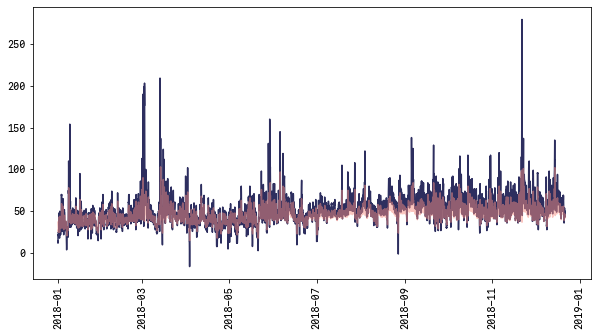

In [19]:
####################################################################################################
# Pre

actual_pred = prediction

# actual_pred = pd.DataFrame()

# actual_pred['Actual'] = features['ID3'][0:len(prediction)]
# actual_pred['Predicted'] = prediction[:, 0]

####################################################################################################
# Plot 1

fig, ax = plt.subplots(figsize = (10 ,5))

x, y = actual_pred.index, actual_pred['Actual']

ax.plot(x, y)

####################################################################################################
# Plot 2

x, y = actual_pred.index, actual_pred['Predicted']

ax.plot(x, y, alpha = 0.5)

plt.xticks(rotation = 90);

In [20]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(actual_pred['Actual'], actual_pred['Predicted'])

15.180757829425401